In [417]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
import re
import scipy.io as scio
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (8, 6)
%config InlineBackend.figure_format = 'retina'

In [126]:
path_to_mrm = 'mrm_data/'
path_to_aepw3 = '../pazy-aepw3-results/'

In [457]:
file_names = {}
file_names['0'] = {'mrm': 'AE results from MRM of UM beam model wing 1 WO skin',
                  'results': 'mrm_umbeam_wo_skin'}
file_names['1'] = {'mrm': 'AE results from MRM of UM beam model wing 1 W skin',
                  'results': 'mrm_umbeam_w_skin'}
file_names['2'] = {'mrm': 'AE results from MRM of Nastran model wing 1',
                  'results': 'mrm_nastran'}
file_names['3'] = {'mrm': 'AE results from MRM of Nastran model wing 1 with weight',
                  'results': 'mrm_nastran_te1'}
file_names['4'] = {'mrm': 'AE results from MRM of UM beam model wing 1 W skin improved QHH',
                  'results': 'mrm_umbeam_w_skin_qhh'}
file_names['5'] = {'mrm': 'AE results from MRM of UM beam model wing 1 WO skin improved QHH',
                  'results': 'mrm_umbeam_wo_skin_qhh'}
file_names['6'] = {'mrm': 'AE results from MRM of UM beam model wing 1 WO skin refined',
                  'results': 'mrm_umbeam_wo_skin_refined'}
file_names['7'] = {'mrm': 'AE results from MRM of UM beam model wing 1 W skin refined',
                  'results': 'mrm_umbeam_w_skin_refined'}

In [468]:
mat = scio.loadmat(path_to_mrm + file_names['6']['mrm'] + '.mat')

In [469]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Norberto_AoA_Data', 'Norberto_Qhh11_data_constnt_modes', 'Norberto_Qhh11_data_eigen_coords', 'Norberto_Qhh12_data_constnt_modes', 'Norberto_Qhh12_data_eigen_coords', 'Norberto_Qhh13_data_constnt_modes', 'Norberto_Qhh13_data_eigen_coords', 'Norberto_Qhh21_data_constnt_modes', 'Norberto_Qhh21_data_eigen_coords', 'Norberto_Qhh22_data_constnt_modes', 'Norberto_Qhh22_data_eigen_coords', 'Norberto_Qhh23_data_constnt_modes', 'Norberto_Qhh23_data_eigen_coords', 'Norberto_Qhh31_data_constnt_modes', 'Norberto_Qhh31_data_eigen_coords', 'Norberto_Qhh32_data_constnt_modes', 'Norberto_Qhh32_data_eigen_coords', 'Norberto_Qhh33_data_constnt_modes', 'Norberto_Qhh33_data_eigen_coords', 'Norberto_Static_AE_Data', 'Norberto_Vel_Data', 'Norberto_deformations_at_vf_data', 'Norberto_nonmached_flutter_Data', 'Norberto_nonmached_flutter_Data_new', 'Norberto_vf_mached_Data'])

In [460]:
for k, v in mat.items():
    print('\n\n---------------------')
    print('Key:', k)
    try:
        print('Shape: ', v.shape)
        print(v)
    except AttributeError:
        pass



---------------------
Key: __header__


---------------------
Key: __version__


---------------------
Key: __globals__


---------------------
Key: Norberto_AoA_Data
Shape:  (2, 1)


---------------------
Key: Norberto_Qhh11_data_constnt_modes
Shape:  (24, 14, 2)


---------------------
Key: Norberto_Qhh11_data_eigen_coords
Shape:  (24, 14, 2)


---------------------
Key: Norberto_Qhh12_data_constnt_modes
Shape:  (24, 14, 2)


---------------------
Key: Norberto_Qhh12_data_eigen_coords
Shape:  (24, 14, 2)


---------------------
Key: Norberto_Qhh13_data_constnt_modes
Shape:  (24, 14, 2)


---------------------
Key: Norberto_Qhh13_data_eigen_coords
Shape:  (24, 14, 2)


---------------------
Key: Norberto_Qhh21_data_constnt_modes
Shape:  (24, 14, 2)


---------------------
Key: Norberto_Qhh21_data_eigen_coords
Shape:  (24, 14, 2)


---------------------
Key: Norberto_Qhh22_data_constnt_modes
Shape:  (24, 14, 2)


---------------------
Key: Norberto_Qhh22_data_eigen_coords
Shape:  (24

In [443]:
k_vec = np.array([0, 0.0200000000000000, 0.0300000000000000, 0.0400000000000000, 0.0500000000000000, 0.0600000000000000, 0.0700000000000000, 0.100000000000000,
                  0.120000000000000, 0.125000000000000, 0.130000000000000, 0.140000000000000, 0.150000000000000, 0.200000000000000, 0.250000000000000,
                  0.300000000000000, 0.400000000000000, 0.500000000000000, 0.600000000000000, 0.700000000000000, 0.800000000000000, 0.900000000000000, 1, 1.50000000000000])

print('Length k', len(k_vec))

Length k 24


In [422]:
def frequency(mat, i_aoa):
    vels = []
    freqs = []
    for i in range(4):
#         plt.scatter(mat['Norberto_Vel_Data'][:, 0], mat['Norberto_frequency_Data'][:, i, 0])
        vels.append(mat['Norberto_Vel_Data'][:, 0].astype(float))
        freqs.append(mat['Norberto_frequency_Data'][:, i, i_aoa])
    vels = np.concatenate(vels)
    freqs = np.concatenate(freqs)
    order = np.argsort(vels)
    vels = np.array([vels[i] for i in order])
    freqs = np.array([freqs[i] for i in order])
#     print(vels)
#     print(freqs)
#     plt.scatter(vels, freqs)
    return vels, freqs

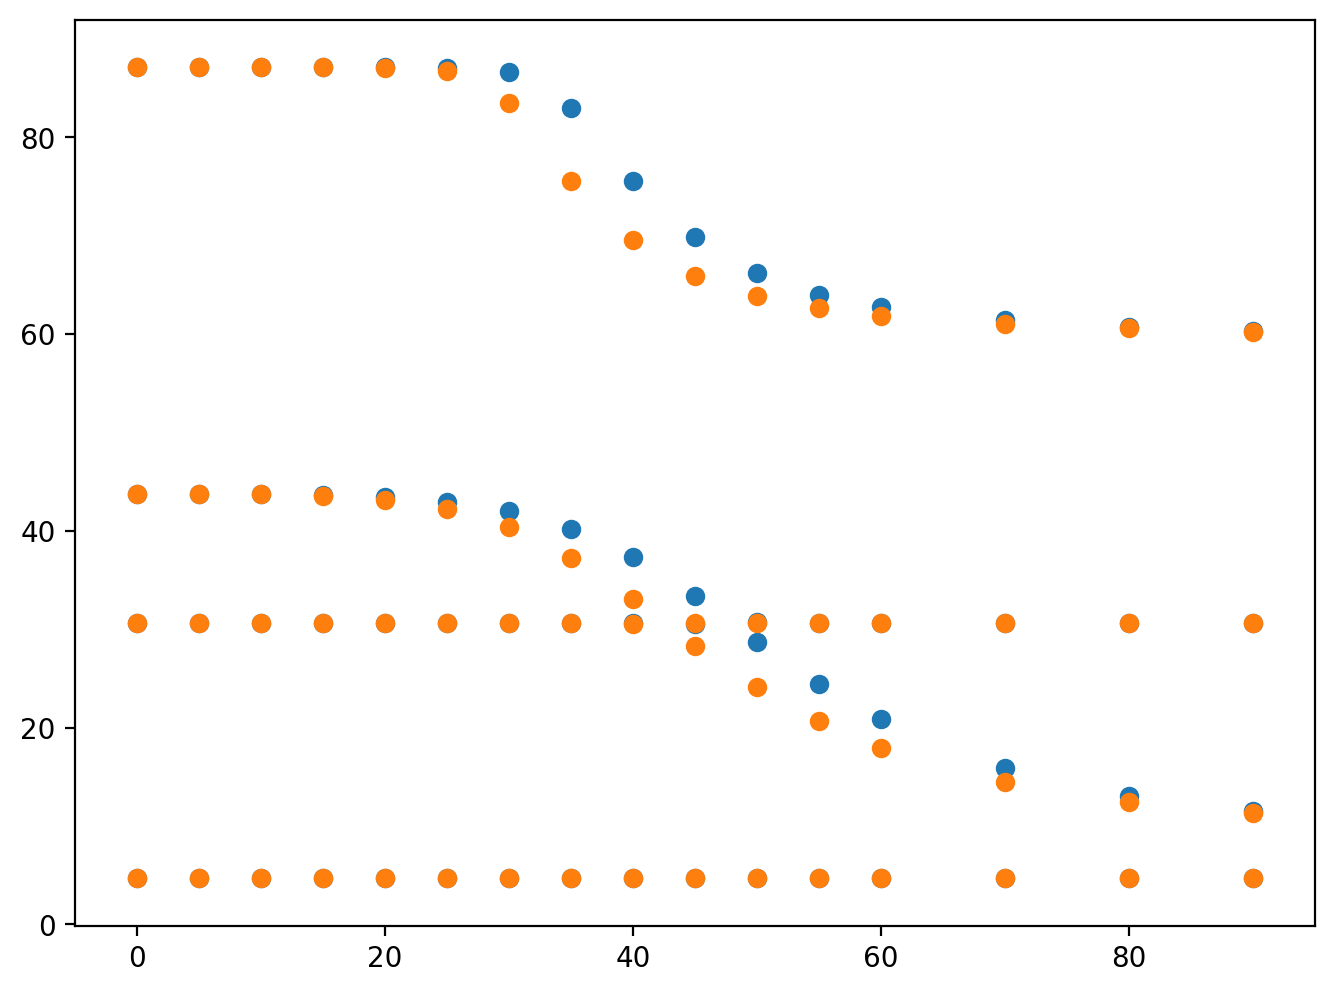

In [423]:
plt.scatter(*frequency(mat, 0))
plt.scatter(*frequency(mat, 1))

In [424]:
def static_deflection_speed(mat, i_aoa):
    vels = mat['Norberto_Vel_Data'][:, 0].astype(float)
    deflection = mat['Norberto_Static_AE_Data'][:, i_aoa]

    return vels, deflection

In [425]:
def matched_flutter(mat, i_aoa):
    if i_aoa is not None:
        deflection = mat['Norberto_Static_AE_Data'][:, i_aoa]
        vels = mat['Norberto_Vel_Data'][:, 0].astype(float)
        flutter_speed = mat['Norberto_vf_mached_Data'][0, i_aoa+1]
        deflection_at_vf = np.interp(flutter_speed, vels, deflection)
    
        return flutter_speed, deflection_at_vf
    else:
        return mat['Norberto_vf_mached_Data'][0, 0], 0

In [426]:
def nonmatched_flutter(mat, i_aoa):
    deflection = mat['Norberto_Static_AE_Data'][:, i_aoa]
    vels = mat['Norberto_Vel_Data'][:, 0].astype(float)
    flutter_speed = mat['Norberto_nonmached_flutter_Data'][:, 0, i_aoa]
    print(flutter_speed)
#     deflection_at_vf = np.interp(flutter_speed, vels, deflection)
    return deflection, flutter_speed

In [470]:
def aero_freqresp(mat, aoa, i_aoa, path):
    mlist = [1, 2, 3]
    plist = [1, 2, 3]
    vels = mat['Norberto_Vel_Data'][:, 0].astype(float)
    
    for i_vel, vel in enumerate(vels):
        print(vel)
        file_path = path + '_uinf{:04g}_alpha{:04g}'.format(vel * 10, aoa* 100)
        os.makedirs(file_path, exist_ok=True)
        for i_p, p in enumerate(plist):
            for i_m, m in enumerate(mlist):
                try:
                    raw_freq = mat['Norberto_Qhh{:g}{:g}_data'.format(p, m)]
                except KeyError:
#                     raw_freq = mat['Norberto_Qhh{:g}{:g}_data_eigen_coords'.format(p, m)]
                    raw_freq = mat['Norberto_Qhh{:g}{:g}_data_constnt_modes'.format(p, m)]



                np.savetxt(file_path + '/in{:02g}_out{:02g}.txt'.format(i_p, i_m), np.column_stack((k_vec, raw_freq[:, i_vel, i_aoa].real, raw_freq[:, i_vel, i_aoa].imag)))


[82.00252426 82.00198104 81.9992319  81.99426994 82.02048294 82.35632116
 92.32000513 91.41115772 89.81041086 87.14341327 83.00050292 77.2270832
 68.59110862 52.18596881 41.93399744 36.10869755]
[82.00252426 82.0017065  81.99732675 81.99719376 82.15937207 92.43942024
 91.50782667 89.80641584 86.94258634 82.55973705 76.636157   67.95147563
 59.49895227 47.01593231 39.67567796 35.36399788]


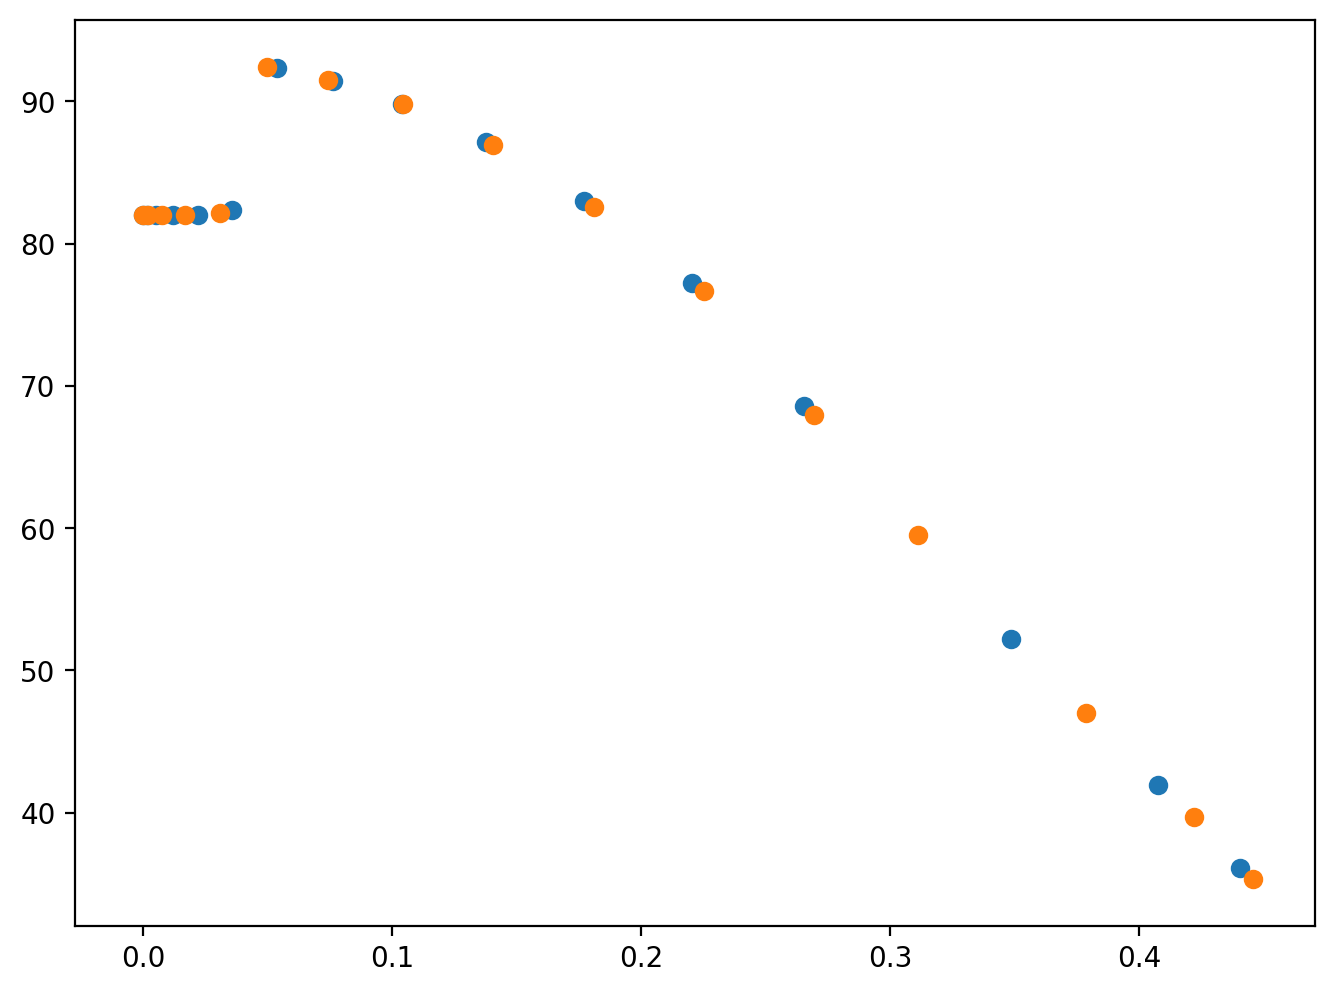

In [453]:
plt.scatter(*nonmatched_flutter(mat, 0))
plt.scatter(*nonmatched_flutter(mat, 1))

# Save in AEPW3

In [463]:
import os
for i in range(len(file_names)):
    
    if not os.path.isdir(path_to_aepw3 + '/06_DeformedWingFlutter/' + file_names[str(i)]['results']):
        os.makedirs(path_to_aepw3 + '/06_DeformedWingFlutter/' + file_names[str(i)]['results'])
    
    mat = scio.loadmat(path_to_mrm + '/' + file_names[str(i)]['mrm'] + '.mat')
    aoa = [5., 7.]
    for i_aoa in range(2):
        # VELOCITY FREQUENCY
        vels, freq = frequency(mat, i_aoa)
        np.savetxt(path_to_aepw3 + '/06_DeformedWingFlutter/' + file_names[str(i)]['results'] + '/velocity_frequency_alpha{:04g}.txt'.format(aoa[i_aoa] * 100),
                  np.column_stack((vels, freq)))
        
        # STATIC DEFLECTION SPEED
        vels, deflection = static_deflection_speed(mat, i_aoa)
        np.savetxt(path_to_aepw3 + '/03_StaticAeroelastic/' + file_names[str(i)]['results'] + '_alpha{:04g}.txt'.format(aoa[i_aoa] * 100),
                  np.column_stack((vels, deflection)))
        
        # DEFORMED FLUTTER
        vf, deflection = matched_flutter(mat, i_aoa)
        np.savetxt(path_to_aepw3 + '/06_DeformedWingFlutter/' + file_names[str(i)]['results'] + '/flutter_speeds_alpha{:04g}.txt'.format(aoa[i_aoa] * 100),
                  np.column_stack((vf, deflection)))
        
        # NONMATCHED FLUTTER
        deflection, vf = nonmatched_flutter(mat, i_aoa)
        np.savetxt(path_to_aepw3 + '/06_DeformedWingFlutter/' + file_names[str(i)]['results'] + '/nonmatched_flutter_speeds_alpha{:04g}.txt'.format(aoa[i_aoa] * 100),
                  np.column_stack((deflection / 0.55, vf)))
        
        # AERO FREQRESP
        path = './06_LinUVLM/output/postprocess/{:s}'.format(file_names[str(i)]['results'])
        try:
            aero_freqresp(mat, aoa[i_aoa], i_aoa, path)
        except KeyError:
            pass
    # STRAIGHT WING FLUTTER
    vf, deflection = matched_flutter(mat, None)
    np.savetxt(path_to_aepw3 + '/06_DeformedWingFlutter/' + file_names[str(i)]['results'] + '/flutter_speeds_alpha{:04g}.txt'.format(0.),
              np.column_stack((vf, deflection)))

[58.03365703 58.03700419 57.989571   57.70176693 56.78965266 54.5051122
 48.45923069 36.61111638 77.48961913 71.45483444 64.39662565 55.96015333
 48.93995    43.52917359 39.45171168 36.40148163]
0.0
[58.03365703 58.03568366 57.9289738  57.33949822 55.4804002  50.1779038
 38.47338685 77.63031329 71.32258708 64.06155055 55.73001072 48.95857502
 43.83439703 40.11782797 37.14643291 34.93189197]
0.0
[73.38548123 73.38334733 73.35202546 73.21277577 72.84055906 72.26743172
 85.98758345 83.66349546 79.57996018 73.34885923 65.62367188 55.98568905
 47.95894845 41.99640033 37.71205604 34.13993538]
0.0
[73.38548123 73.38133947 73.32035305 73.05518292 72.44627333 86.34437387
 84.11019365 80.08328582 73.93141953 66.38050607 57.22887361 49.40509018
 43.54003161 39.27490661 35.88534453 33.21624595]
0.0
[62.35891358 62.36060834 62.34369178 62.23860588 61.91828265 61.18130458
 59.72364693 57.02229262 51.56503396 43.38704584 84.30781151 79.51802851
 73.80778836 59.23730235 47.72031159 39.09741117]
0.0
[6

KeyError: 'Norberto_frequency_Data'

In [471]:
import os
for i in range(len(file_names)-2, len(file_names)):
    
    if not os.path.isdir(path_to_aepw3 + '/06_DeformedWingFlutter/' + file_names[str(i)]['results']):
        os.makedirs(path_to_aepw3 + '/06_DeformedWingFlutter/' + file_names[str(i)]['results'])
    
    mat = scio.loadmat(path_to_mrm + '/' + file_names[str(i)]['mrm'] + '.mat')
    aoa = [5., 7.]
    for i_aoa in range(2):
        # AERO FREQRESP
        path = './06_LinUVLM/output/postprocess/{:s}'.format(file_names[str(i)]['results'])
        try:
            aero_freqresp(mat, aoa[i_aoa], i_aoa, path)
        except KeyError:
            pass

0.0
1.0
5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0
0.0
1.0
5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0
0.0
1.0
5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0
0.0
1.0
5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0


In [373]:
cs = []
thrust = []
with open('/home/ng213/2TB/HH_HALE/09_MPC_Simulation/output/simple_HALE_mpc_mass_centredrop/input_history.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        ll = line.split(',')
        try:
            cs.append(float(ll[0]))
            thrust.append(float(ll[1]))
        except ValueError:
            pass
        
cs = np.array(cs)
thrust = np.array(thrust)

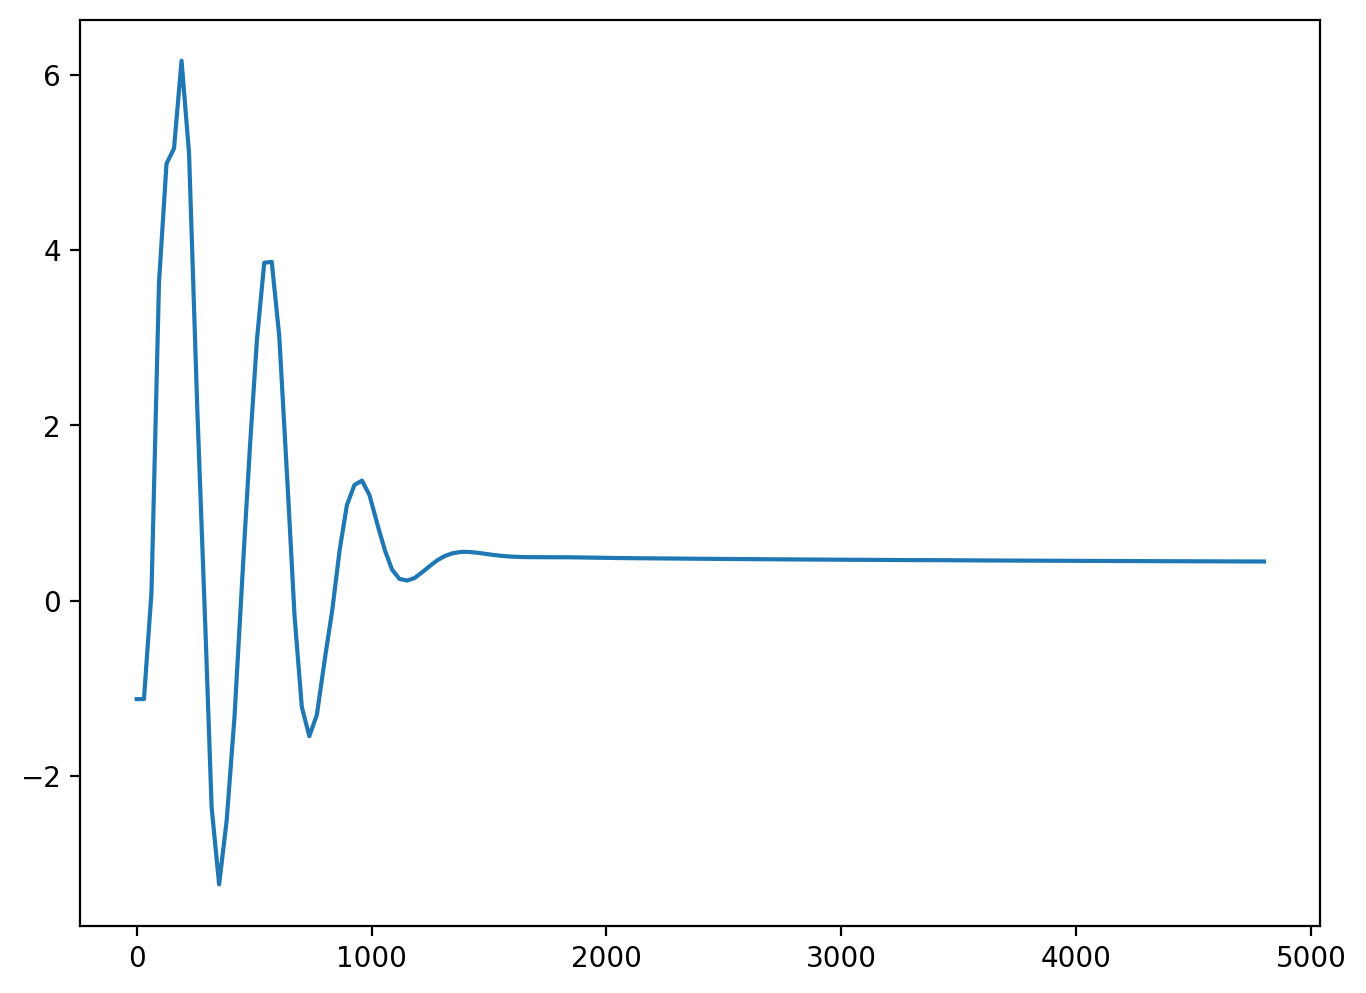

In [374]:
plt.plot(cs * 180 / np.pi)

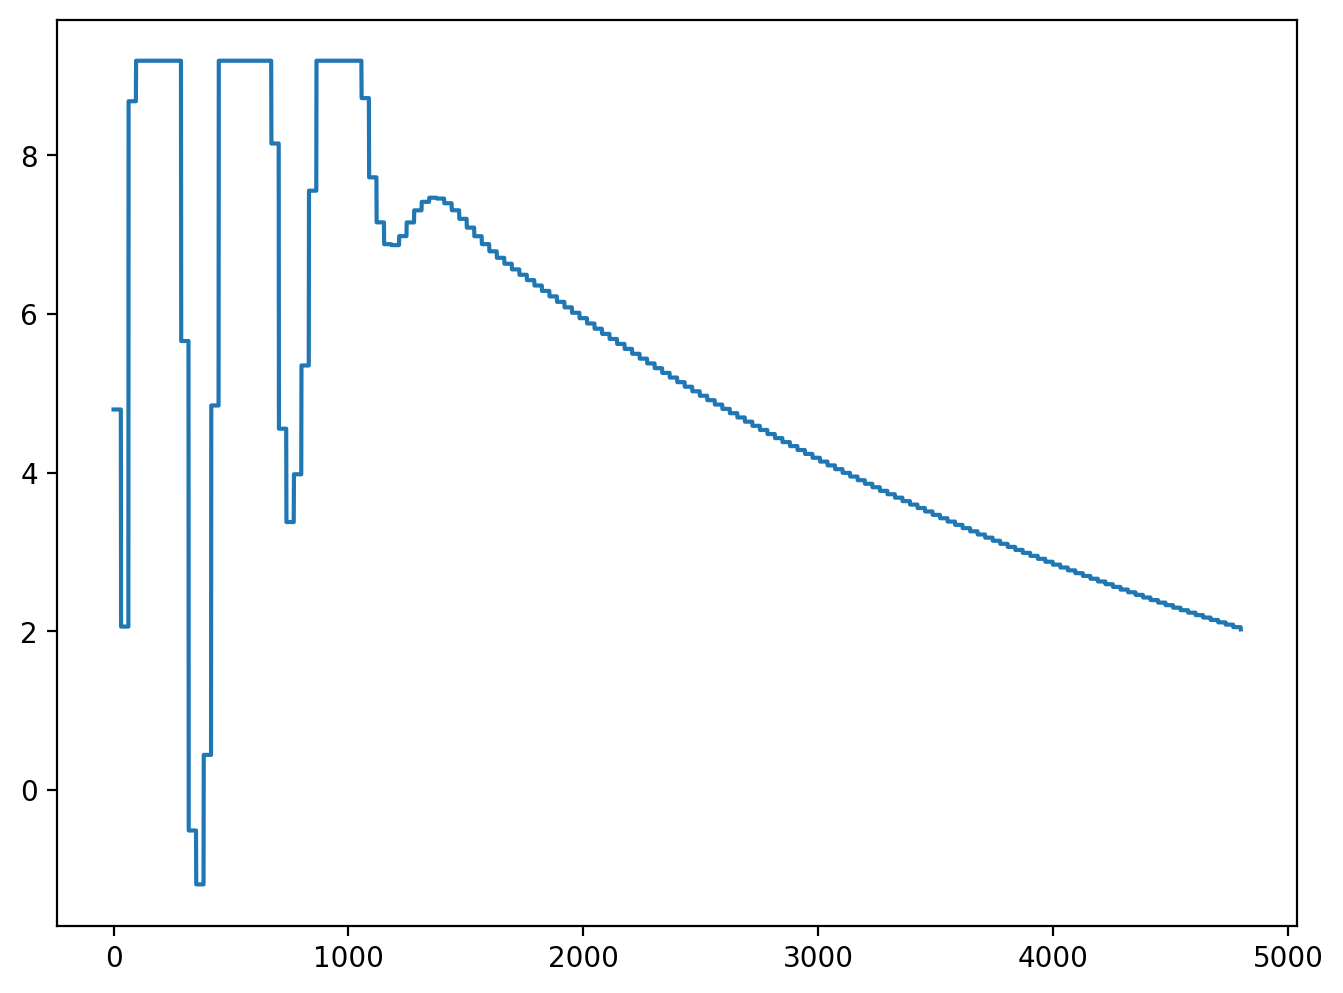

In [375]:
plt.plot(thrust)

In [376]:
ol = np.loadtxt('/home/ng213/2TB/HH_HALE/03_PayloadDrop/output/simple_HALE_mass_centredrop/WriteVariablesTime/FoR_00_for_pos.dat')

In [377]:
cl = np.loadtxt('/home/ng213/2TB/HH_HALE/09_MPC_Simulation/output/simple_HALE_mpc_mass_centredrop/WriteVariablesTime/FoR_00_for_pos.dat')

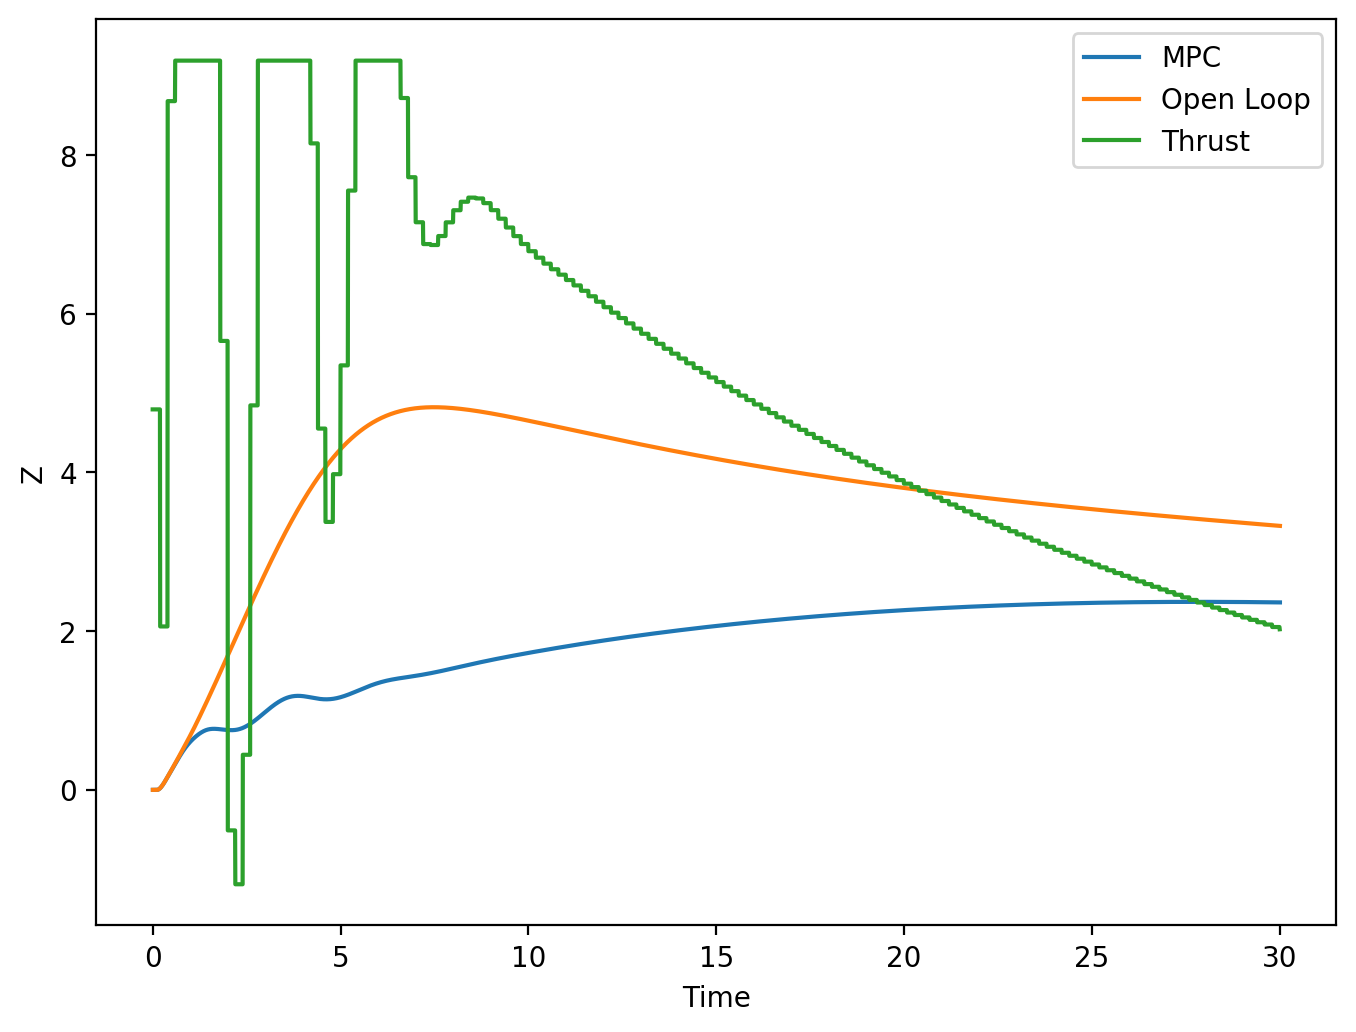

In [378]:
plt.plot(cl[:, 0] / 160, cl[:, 3], label='MPC')
plt.plot(ol[:, 0] / 160, ol[:ol.shape[0], 3], label='Open Loop')

plt.plot(np.arange(len(thrust)) / 160, thrust, label='Thrust')
plt.xlabel('Time')
plt.ylabel('Z')
plt.legend()
# plt.xlim(0, 6)

In [379]:
vel_cl = np.loadtxt('/home/ng213/2TB/HH_HALE/09_MPC_Simulation/output/simple_HALE_mpc_mass_centredrop/WriteVariablesTime/FoR_00_for_vel.dat')

In [380]:
vel_ol = np.loadtxt('/home/ng213/2TB/HH_HALE/03_PayloadDrop/output/simple_HALE_mass_centredrop/WriteVariablesTime/FoR_00_for_vel.dat')

In [381]:
aoa_cl = np.arctan(vel_cl[:, 3]/vel_cl[:, 1])
aoa_ol = np.arctan(vel_ol[:, 3]/vel_ol[:, 1])

Text(0, 0.5, 'Angle of attack, deg')

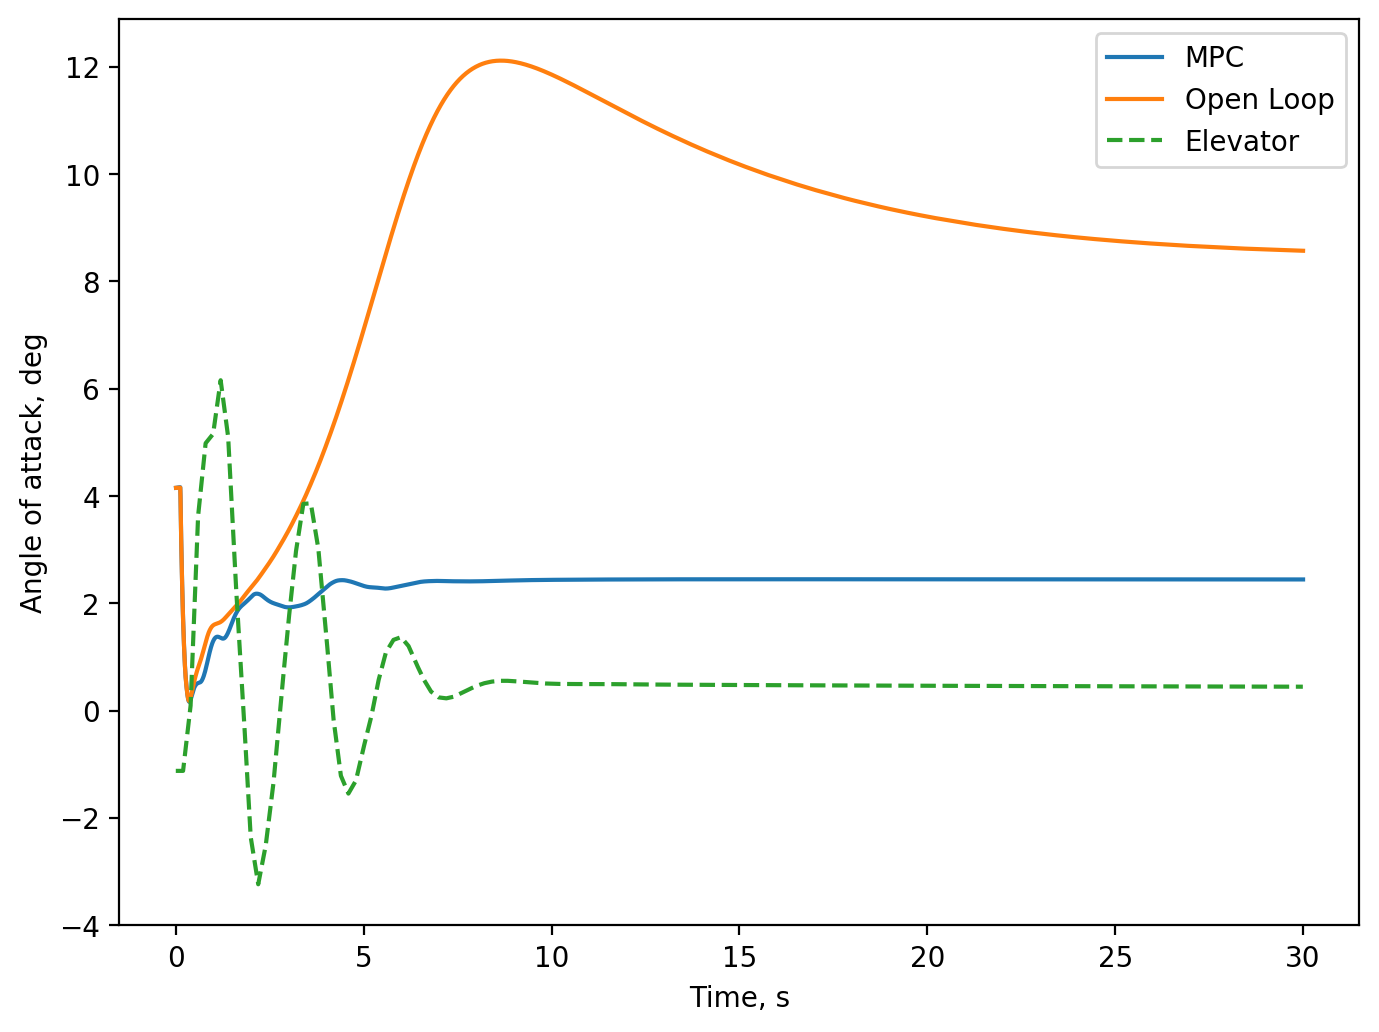

In [382]:
plt.plot(cl[:, 0] / 160, aoa_cl * 180 / np.pi, label='MPC')
plt.plot(ol[:, 0] / 160, aoa_ol * 180 / np.pi, label='Open Loop')
plt.plot(np.arange(len(cs)) / 160, cs * 180 / np.pi, ls='--', label='Elevator')

# plt.xlim(0, 6)
plt.legend()
plt.xlabel('Time, s')
plt.ylabel('Angle of attack, deg')

Text(0, 0.5, 'True Airspeed, m/s')

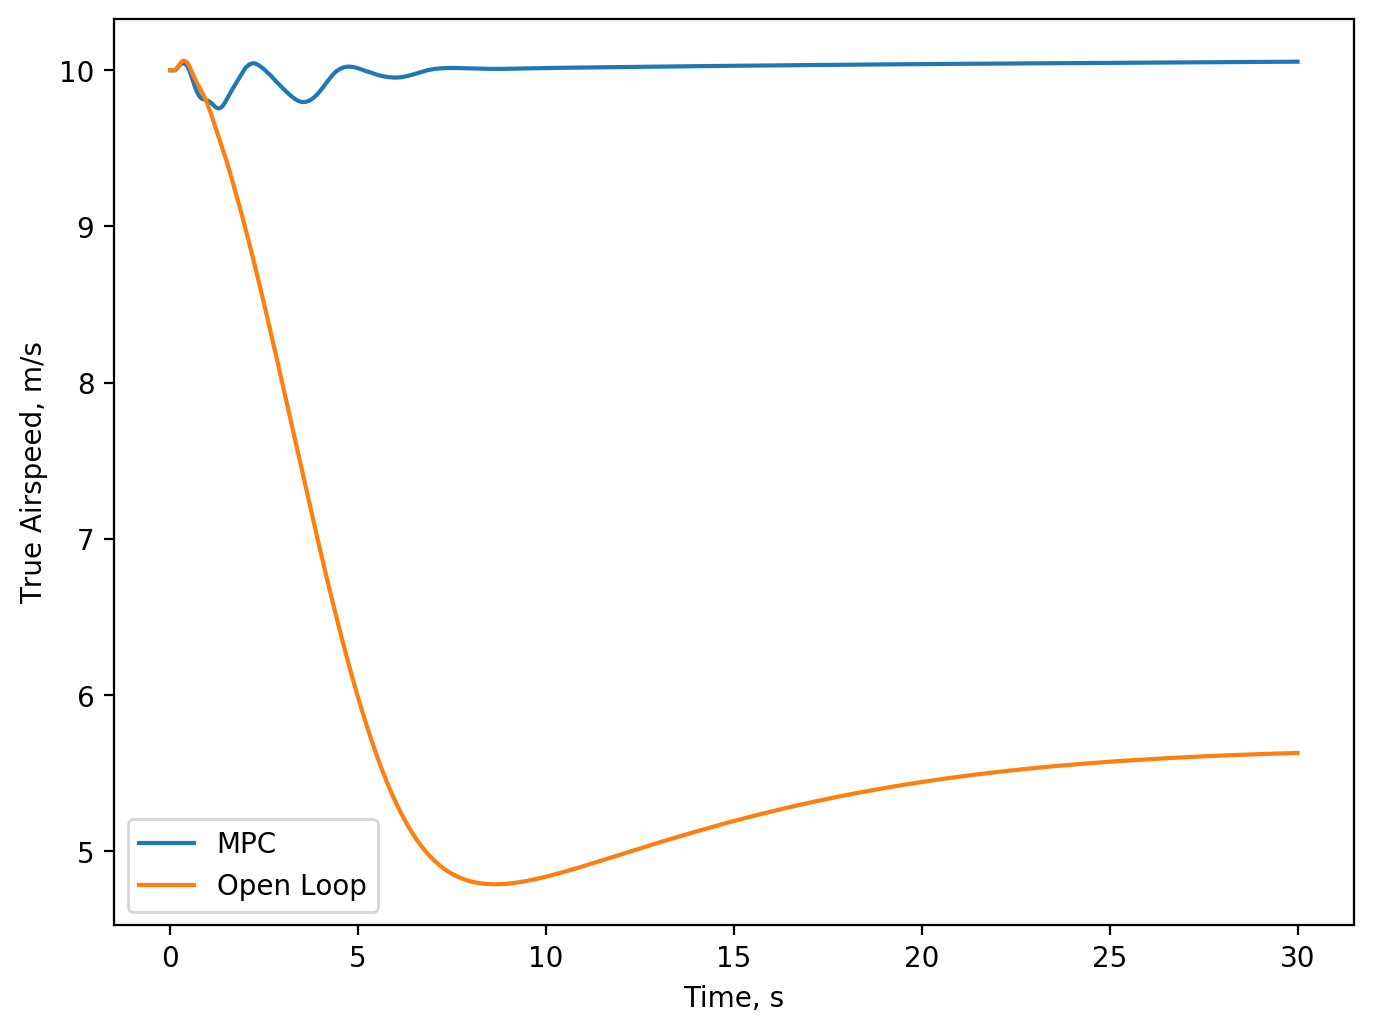

In [383]:
plt.plot(cl[:, 0] / 160, np.linalg.norm(vel_cl[:, 1:], axis=1), label='MPC')
plt.plot(ol[:, 0] / 160, np.linalg.norm(vel_ol[:, 1:], axis=1), label='Open Loop')

# plt.xlim(0, 6)
plt.legend()
plt.xlabel('Time, s')
plt.ylabel('True Airspeed, m/s')